## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\zuoo5\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zuoo5\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zuoo5\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\zuoo5\Anaco

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 50 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.8, 0.3]
redice_lr_patient = [2, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.80, reduce_patient: 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 41us/step - loss: 0.7343 - acc: 0.7709 - val_loss: 1.4915 - val_acc: 0.5035

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.
Epoch 45/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7302 - acc: 0.7713 - val_loss: 1.4917 - val_acc: 0.5065
Epoch 46/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7261 - acc: 0.7740 - val_loss: 1.4948 - val_acc: 0.5057

Epoch 00046: ReduceLROnPlateau reducing learning rate to 8.589935605414213e-05.
Epoch 47/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.7239 - acc: 0.7750 - val_loss: 1.4930 - val_acc: 0.5083
Epoch 48/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7215 - acc: 0.7768 - val_loss: 1.4952 - val_acc: 0.5056

Epoch 00048: ReduceLROnPlateau reducing learning rate to 6.871948717162013e-05.
Epoch 49/50
50000/50000 [==============================] - 2s 41us/step - loss

50000/50000 [==============================] - 2s 42us/step - loss: 1.5512 - acc: 0.4589 - val_loss: 1.6786 - val_acc: 0.4170
Epoch 41/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5455 - acc: 0.4608 - val_loss: 1.6754 - val_acc: 0.4176
Epoch 42/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5398 - acc: 0.4621 - val_loss: 1.6724 - val_acc: 0.4187
Epoch 43/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5342 - acc: 0.4648 - val_loss: 1.6692 - val_acc: 0.4213
Epoch 44/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.5292 - acc: 0.4650 - val_loss: 1.6652 - val_acc: 0.4205
Epoch 45/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5245 - acc: 0.4693 - val_loss: 1.6627 - val_acc: 0.4211
Epoch 46/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5191 - acc: 0.4702 - val_loss: 1.6596 - val_acc: 0.4233
Epoch 47/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 42us/step - loss: 1.5624 - acc: 0.4526 - val_loss: 1.6691 - val_acc: 0.4127
Epoch 39/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5554 - acc: 0.4544 - val_loss: 1.6658 - val_acc: 0.4129
Epoch 40/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.5506 - acc: 0.4568 - val_loss: 1.6617 - val_acc: 0.4154
Epoch 41/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5455 - acc: 0.4586 - val_loss: 1.6582 - val_acc: 0.4163
Epoch 42/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5410 - acc: 0.4602 - val_loss: 1.6558 - val_acc: 0.4170
Epoch 43/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5355 - acc: 0.4622 - val_loss: 1.6523 - val_acc: 0.4173
Epoch 44/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5311 - acc: 0.4641 - val_loss: 1.6489 - val_acc: 0.4173
Epoch 45/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 42us/step - loss: 1.5691 - acc: 0.4545 - val_loss: 1.6868 - val_acc: 0.4142
Epoch 37/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5634 - acc: 0.4573 - val_loss: 1.6820 - val_acc: 0.4151
Epoch 38/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5580 - acc: 0.4585 - val_loss: 1.6786 - val_acc: 0.4155
Epoch 39/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5524 - acc: 0.4602 - val_loss: 1.6753 - val_acc: 0.4166
Epoch 40/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5468 - acc: 0.4630 - val_loss: 1.6721 - val_acc: 0.4170
Epoch 41/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5417 - acc: 0.4648 - val_loss: 1.6681 - val_acc: 0.4213
Epoch 42/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5357 - acc: 0.4673 - val_loss: 1.6650 - val_acc: 0.4205
Epoch 43/50
50000/50000 [=====================


Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
Epoch 30/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.2639 - acc: 0.9411 - val_loss: 1.7366 - val_acc: 0.5181
Epoch 31/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.2517 - acc: 0.9450 - val_loss: 1.7465 - val_acc: 0.5156

Epoch 00031: ReduceLROnPlateau reducing learning rate to 0.00010737419361248613.
Epoch 32/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.2405 - acc: 0.9490 - val_loss: 1.7675 - val_acc: 0.5216
Epoch 33/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.2296 - acc: 0.9524 - val_loss: 1.7960 - val_acc: 0.5150

Epoch 00033: ReduceLROnPlateau reducing learning rate to 8.589935605414213e-05.
Epoch 34/50
50000/50000 [==============================] - 2s 45us/step - loss: 0.2181 - acc: 0.9589 - val_loss: 1.7906 - val_acc: 0.5195
Epoch 35/50
50000/50000 [==============================] - 2s 44u

50000/50000 [==============================] - 2s 44us/step - loss: 1.1904 - acc: 0.5952 - val_loss: 1.4964 - val_acc: 0.4776
Epoch 23/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1787 - acc: 0.5992 - val_loss: 1.4974 - val_acc: 0.4789
Epoch 24/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1686 - acc: 0.6029 - val_loss: 1.4980 - val_acc: 0.4781
Epoch 25/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1579 - acc: 0.6086 - val_loss: 1.4927 - val_acc: 0.4783
Epoch 26/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1472 - acc: 0.6131 - val_loss: 1.4865 - val_acc: 0.4803
Epoch 27/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.1377 - acc: 0.6173 - val_loss: 1.4833 - val_acc: 0.4842
Epoch 28/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1276 - acc: 0.6193 - val_loss: 1.4819 - val_acc: 0.4843
Epoch 29/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 44us/step - loss: 1.1967 - acc: 0.5919 - val_loss: 1.4827 - val_acc: 0.4798
Epoch 21/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1849 - acc: 0.5949 - val_loss: 1.4774 - val_acc: 0.4811
Epoch 22/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1734 - acc: 0.5998 - val_loss: 1.4774 - val_acc: 0.4813
Epoch 23/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1632 - acc: 0.6050 - val_loss: 1.4739 - val_acc: 0.4776
Epoch 24/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1538 - acc: 0.6075 - val_loss: 1.4783 - val_acc: 0.4806
Epoch 25/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1409 - acc: 0.6128 - val_loss: 1.4672 - val_acc: 0.4835
Epoch 26/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.1303 - acc: 0.6180 - val_loss: 1.4659 - val_acc: 0.4833
Epoch 27/50
50000/50000 [=====================

Epoch 14/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0630 - acc: 0.0997 - val_loss: 3.0686 - val_acc: 0.1016
Epoch 15/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0639 - acc: 0.0996 - val_loss: 3.0685 - val_acc: 0.1014
Epoch 16/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0630 - acc: 0.1004 - val_loss: 3.0684 - val_acc: 0.1015
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0629 - acc: 0.1004 - val_loss: 3.0681 - val_acc: 0.1018
Epoch 18/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0632 - acc: 0.1000 - val_loss: 3.0679 - val_acc: 0.1018
Epoch 19/50
50000/50000 [==============================] - 2s 43us/step - loss: 3.0615 - acc: 0.1002 - val_loss: 3.0678 - val_acc: 0.1017
Epoch 20/50
50000/50000 [==============================] - 2s 44us/step - loss: 3.0615 - acc: 0.0998 - val_loss: 3.0679 - val_acc: 0.1016
Epoch 21/50
50000/50000 [=========

50000/50000 [==============================] - 2s 42us/step - loss: 0.9535 - acc: 0.6704 - val_loss: 1.6002 - val_acc: 0.4553
Epoch 12/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.9173 - acc: 0.6834 - val_loss: 1.4962 - val_acc: 0.4821
Epoch 13/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8872 - acc: 0.6936 - val_loss: 1.4803 - val_acc: 0.4939
Epoch 14/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.8573 - acc: 0.7061 - val_loss: 1.5858 - val_acc: 0.4610
Epoch 15/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.8263 - acc: 0.7172 - val_loss: 1.5601 - val_acc: 0.4797
Epoch 16/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.8007 - acc: 0.7249 - val_loss: 1.5594 - val_acc: 0.4920

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.00040960004553198815.
Epoch 17/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.7487 - acc: 0.7455 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 73us/step - loss: 2.5169 - acc: 0.1938 - val_loss: 2.3686 - val_acc: 0.2268
Epoch 2/50
50000/50000 [==============================] - 2s 43us/step - loss: 2.1442 - acc: 0.2787 - val_loss: 2.1559 - val_acc: 0.2810
Epoch 3/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.9792 - acc: 0.3216 - val_loss: 2.0290 - val_acc: 0.3092
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.8773 - acc: 0.3532 - val_loss: 1.9340 - val_acc: 0.3365
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.8057 - acc: 0.3729 - val_loss: 1.8719 - val_acc: 0.3542
Epoch 6/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.7511 - acc: 0.3922 - val_loss: 1.8316 - val_acc: 0.3735
Epoch 7/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.7058 - acc: 0.4057 - val_loss: 1.7899 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 81us/step - loss: 2.4343 - acc: 0.2144 - val_loss: 2.2342 - val_acc: 0.2652
Epoch 2/50
50000/50000 [==============================] - 2s 44us/step - loss: 2.0980 - acc: 0.2941 - val_loss: 2.0807 - val_acc: 0.3034
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.9525 - acc: 0.3359 - val_loss: 1.9912 - val_acc: 0.3298
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.8581 - acc: 0.3621 - val_loss: 1.9181 - val_acc: 0.3437
Epoch 5/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.7898 - acc: 0.3824 - val_loss: 1.8564 - val_acc: 0.3631
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.7363 - acc: 0.3985 - val_loss: 1.8222 - val_acc: 0.3698
Epoch 7/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.6944 - acc: 0.4121 - val_loss: 1.7926 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 81us/step - loss: 2.4969 - acc: 0.2060 - val_loss: 2.3135 - val_acc: 0.2530
Epoch 2/50
50000/50000 [==============================] - 2s 46us/step - loss: 2.1385 - acc: 0.2910 - val_loss: 2.1499 - val_acc: 0.2938
Epoch 3/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.9856 - acc: 0.3303 - val_loss: 2.0236 - val_acc: 0.3234
Epoch 4/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.8852 - acc: 0.3571 - val_loss: 1.9435 - val_acc: 0.3403
Epoch 5/50
50000/50000 [==============================] - 2s 44us/step - loss: 1.8125 - acc: 0.3778 - val_loss: 1.8973 - val_acc: 0.3556
Epoch 6/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.7571 - acc: 0.3950 - val_loss: 1.8334 - val_acc: 0.3770
Epoch 7/50
50000/50000 [==============================] - 2s 45us/step - loss: 1.7114 - acc: 0.4105 - val_loss: 1.8176 - val_acc

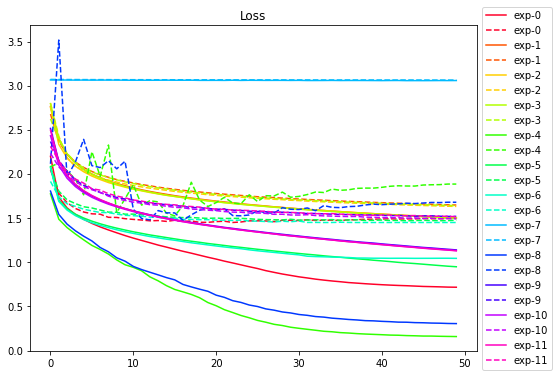

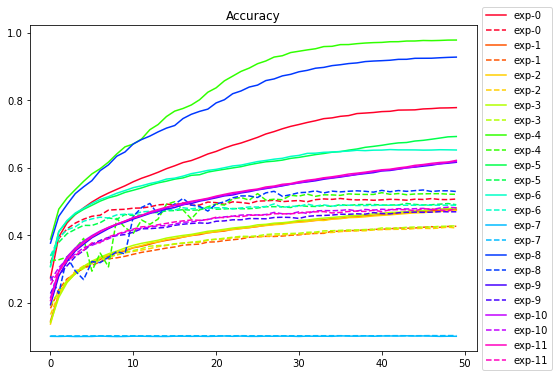

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()